# iGED : Global Systems Dynamics Initiative

El objetivo principal de este documento es analizar las métricas globales en las siguientes redes capitales

  *  Ciudad Autónoma de Buenos Aires (CABA)
  *  Ciudad de México (CDMX)
  *  Santiago de Chile (SCL)
  *  Montevideo (MTV)
  *  Madrid (MAD)
  *  Sao Paulo (SAO)

y obtener un tidy DataFrame, para continuar analizando los datos obtenidos, por ejemplo obteniendo correlaciones entre parejas de métricas.

Respecto al notebook anterior, utilizamos la documentación de NetworkX: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

así como el siguiente recurso: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

para saber con cuáles métricas globales seguir estudiando nuestros ecosistemas.

In [1]:
#-------------------------------------------------------
# Importar paquetes a utilizar
#-------------------------------------------------------
import pandas as pd
import numpy as np 
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

G={}

for i in range(10):
    G[i]=nx.read_graphml('Random_Graphs/Random_Graph_'+str(i+1)+'.graphml')


In [2]:
#--------------------------------
# Central point of Dominance
#--------------------------------


def central_point_dominance(G):
    betwennesses = nx.betweenness_centrality(G)
    b_max = max(betwennesses.values())
    N = len(betwennesses.keys())
    count = 0
    for i, b_i in betwennesses.items():
        count += ( b_max - b_i )/(N-1)
    return count

In [3]:
#--------------------------------
# Spectral Radius
#--------------------------------
#     the smaller the spectral radius rho, the higher the probability of 'virus infection' tau, 
#     the more difficult it is for an idea to spread in the innovative network, 
#     namely, the less efficient

import numpy.linalg

def spectral_radius(G):
    L = nx.normalized_laplacian_matrix(G)
    e = numpy.linalg.eigvals(L.A)
    e_abs = [abs(x) for x in e]
    return max(e_abs)

In [4]:
def core_ratio(G):
    return len(nx.k_core(G,k=2).nodes())/len(G.nodes())

In [5]:
def rich_club_coeffs(G):
    t_ok = True
    t = 0
    d = dict()
    while t_ok:
        nodes_large_degree=[]
        for x in G.nodes():
            if G.degree(x)>t:
                nodes_large_degree.append(x)
        core = G.subgraph(nodes_large_degree)
        edges_core = len(core.edges())
        nodes_core = len(core.nodes())
        if nodes_core<=1:
            t_ok = False
            break
        d[t] = (2*edges_core)/(nodes_core*(nodes_core-1))
        t += 1 
    return d        

def max_rich_club(G):
    #rich_club_1=nx.algorithms.rich_club_coefficient(G, normalized=False)
    rich_club=rich_club_coeffs(G)
    max_i=0
    
    for i in range(len(rich_club)):
        if rich_club[i]>rich_club[max_i]:
            max_i=i
    return rich_club[max_i]

## Creacion del Dataframe

El siguiente bloque crea todas las metricas de la grafica que usaremos para estudiarlas.

In [6]:
n=len(G)

degree = n*[0]
diameter = n*[0]
radius = n*[0]
avg_shortest_path_length = n*[0]
transitivity = n*[0]
global_efficiency = n*[0]
modularity = n*[0]
rich_club_coefficient = n*[0]
core_rate= n*[0]
central_pt = n*[0]
spectral_radii = n*[0]

for index in G.keys():
    graph=G[index]
    
    #conseguimos cada parámetro para esta ciudad
    diameter[index] =                     nx.diameter(graph)
    radius[index] =                       nx.radius(graph)
    avg_shortest_path_length[index] =     nx.average_shortest_path_length(graph)
    transitivity[index] =                 nx.transitivity(graph)
    global_efficiency[index] =            nx.global_efficiency(graph)
    #modularidad precomputada
    rich_club_coefficient[index] =        max_rich_club(graph)  
    core_rate[index]=                     core_ratio(graph)
    central_pt[index]=       central_point_dominance(graph)
    spectral_radii[index]=               spectral_radius(graph)

df=pd.DataFrame()

for index in G.keys():
    df['Diámetro'] = diameter
    df['Radio'] = radius
    df['Camino más corto promedio'] = avg_shortest_path_length
    df['Transitividad'] = transitivity
    df['Eficiencia Global'] = global_efficiency
    df['Rich Club Coefficient'] = rich_club_coefficient
    df['Core Ratio'] = core_rate
    df['Central Point Dominance'] = [round(central_pt[index],3) for index in range(n)]
    df['Spectral radius'] = [round(spectral_radii[index],3) for index in range(n)]


df

,Diámetro,Radio,Camino más corto promedio,Transitividad,Eficiencia Global,Rich Club Coefficient,Core Ratio,Central Point Dominance,Spectral radius
0,5,4,3.227126,0.057235,0.342953,0.333333,0.741758,0.117,1.818
1,5,3,2.972036,0.097466,0.374024,0.400000,0.702128,0.144,1.785
2,5,3,3.183248,0.074597,0.349931,0.219780,0.634731,0.103,1.818
3,5,3,3.110753,0.087683,0.358951,1.000000,0.723684,0.119,1.789
4,5,3,3.223024,0.100840,0.343725,0.333333,0.597765,0.130,1.796
5,3,2,2.169935,0.168224,0.523965,1.000000,0.444444,0.647,1.843
6,6,3,3.350386,0.071940,0.329053,0.333333,0.593074,0.119,1.806
7,6,3,3.150365,0.099850,0.353618,0.333333,0.682353,0.142,1.794
8,6,4,3.214849,0.086497,0.347859,0.476190,0.721893,0.158,1.864
9,5,3,3.198695,0.076463,0.345227,0.236364,0.685279,0.113,1.816


## Colaboracion

Empezamos analizando las metricas que ya hemos calculado y luego usaremos esta informacion para crear una medida de la colaboracion.

In [16]:
#---------------------------------------------
#Preparar escalas y herramientas para el analisis.
#---------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X=df.to_numpy()



#normalized= StandardScaler().fit_transform(X)
pca=PCA(n_components=5)
prin_comp=pca.fit_transform(normalized)

pca.components_

array([[-0.34456209, -0.3096399 , -0.38656376,  0.37324149,  0.39011543,
         0.27763128, -0.32511172,  0.38564569,  0.1138856 ],
       [ 0.03903127,  0.49329412, -0.0510798 , -0.04548513,  0.08624874,
         0.02515771,  0.11337932,  0.16660001,  0.83772146],
       [-0.09253905,  0.22352902, -0.10352821, -0.01472904,  0.05977722,
         0.74670271,  0.56077815, -0.05041279, -0.22887644],
       [-0.76601248,  0.16855561, -0.18642236, -0.29404793,  0.12236901,
        -0.41335861,  0.25035117, -0.0314424 , -0.11871206],
       [ 0.34708503,  0.14408779, -0.32131418,  0.52335957,  0.21776432,
        -0.43415186,  0.44419102,  0.11864268, -0.18528832]])

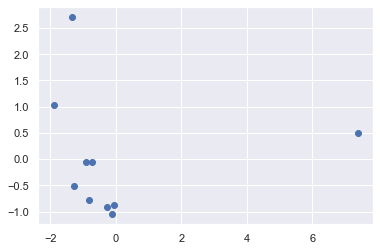

In [12]:
from matplotlib import pyplot as plt
plt.scatter(prin_comp[:,0], prin_comp[:,1],color='b')

In [25]:
#---------------------------------------
# Fórmula para colaboratividad
#---------------------------------------

eg = df['Eficiencia Global'].tolist()
tr = df['Transitividad'].tolist()
comunicacion = [eg[x]+tr[x] for x in range(n)]

r= df['Radio'].tolist()
sr= df['Spectral radius'].tolist()
size=[-r[x]/14+sr[x]/2.5 for x in range(n)]

rcc = df['Rich Club Coefficient'].tolist()
cr = df['Core Ratio'].tolist()
preparacion = [(rcc[x]+cr[x])/2 for x in range(n)]

colab_1 = [comunicacion[x]+preparacion[x]+size[x] for x in range(n)]
colab_1

[1.3792198774350988,
 1.5222685618454208,
 1.3646984713243768,
 1.8097896267060398,
 1.4142289925725238,
 2.008754520042701,
 1.3723106780008814,
 1.4646248618664974,
 1.49328353768662,
 1.3946253362371377]

In [33]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Core Ratio'].tolist()
preparacion = [-rcc[x] for x in range(n)]

colab_1 = [comunicacion[x]+preparacion[x]+size[x] for x in range(n)]
colab_1

[-0.3415698661546451,
 -0.2306372132305669,
 -0.2102017326632524,
 -0.2770509747977198,
 -0.15320000450116614,
 0.24774499623317722,
 -0.19208066399046078,
 -0.228885502279161,
 -0.28753765138072285,
 -0.26358954938485446]

0    0.741758
1    0.702128
2    0.634731
3    0.723684
4    0.597765
5    0.444444
6    0.593074
7    0.682353
8    0.721893
9    0.685279
Name: Core Ratio, dtype: float64